In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rf-tv-dataset/cleaned_tv_dataset_fi.csv


In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import matplotlib.pyplot as plt

# Đảm bảo các kết quả reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dữ liệu & xem sơ bộ

In [4]:
# ============================================================
# Cell 2 - Load dữ liệu & kiểm tra sơ bộ
# ============================================================

# Nếu chạy trên Kaggle và đã upload file theo Input Dataset:
# df = pd.read_csv("/kaggle/input/cleaned_tv_dataset_fi/cleaned_tv_dataset_fi.csv")

# Nếu chạy local / Colab / VSCode (file cùng thư mục notebook):
df = pd.read_csv("/kaggle/input/rf-tv-dataset/cleaned_tv_dataset_fi.csv")

print("Kích thước dữ liệu:", df.shape)
display(df.head())

print("\nKiểu dữ liệu các cột:")
print(df.dtypes)

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isna().sum())


Kích thước dữ liệu: (613, 12)


,price,spec_Backlight_Type,spec_Brand,spec_Display_Type,spec_ENERGY_STAR_Certified,spec_High_Dynamic_Range_HDR,spec_LED_Panel_Type,spec_Model_Year,spec_Refresh_Rate,spec_Remote_Control_Type,spec_Resolution,spec_Screen_Size_Class
0,139.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),43
1,99.99,Direct Lit,TCL,LED,No,No,Standard LED,2025,144,Standard,Full HD (1080p),40
2,109.99,Direct Lit,Insignia,LED,No,No,Standard LED,2025,120,Voice control,Full HD (1080p),40
3,199.99,Direct Lit,Insignia,LED,No,Yes,Standard LED,2025,120,Voice control,4K (2160p),55
4,189.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),50



Kiểu dữ liệu các cột:
price                          float64
spec_Backlight_Type             object
spec_Brand                      object
spec_Display_Type               object
spec_ENERGY_STAR_Certified      object
spec_High_Dynamic_Range_HDR     object
spec_LED_Panel_Type             object
spec_Model_Year                  int64
spec_Refresh_Rate                int64
spec_Remote_Control_Type        object
spec_Resolution                 object
spec_Screen_Size_Class           int64
dtype: object

Số lượng giá trị thiếu mỗi cột:
price                            0
spec_Backlight_Type            207
spec_Brand                       0
spec_Display_Type                0
spec_ENERGY_STAR_Certified       0
spec_High_Dynamic_Range_HDR      0
spec_LED_Panel_Type              0
spec_Model_Year                  0
spec_Refresh_Rate                0
spec_Remote_Control_Type         0
spec_Resolution                  0
spec_Screen_Size_Class           0
dtype: int64


# Tiền xử lý chung

In [5]:

target_col = "price"
y = df[target_col]
X = df.drop(columns=[target_col])

# Phân loại cột số và cột phân loại
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Số cột numeric:", len(numeric_cols))
print("Số cột categorical:", len(categorical_cols))

# Xử lý missing:
#  - numeric: điền median
#  - categorical: điền 'Unknown'
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# One-Hot Encoding các cột phân loại
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Kích thước X sau One-Hot encoding:", X_encoded.shape)

# Train/Test Split - Percentage Split (PS)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, " - Test size:", X_test.shape)


Số cột numeric: 3
Số cột categorical: 8
Kích thước X sau One-Hot encoding: (613, 58)
Train size: (490, 58)  - Test size: (123, 58)


# Hàm đánh giá mô hình (MAE, RMSE, R²)

In [6]:
def evaluate_regression(y_true, y_pred, model_name="Model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"===== {model_name} =====")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}

Random Forest “baseline” với Percentage Split

In [7]:
# ============================================================
# Cell 5 - Random Forest baseline với Percentage Split (80/20)
# ============================================================

rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

metrics_base = evaluate_regression(y_test, y_pred_base, model_name="RF Baseline (PS)")


===== RF Baseline (PS) =====
MAE  : 241.2488
RMSE : 411.7849
R²   : 0.7304


# Thiết lập Repeated K-Fold & bộ scoring cho Cross Validation

In [8]:
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=3,
    random_state=RANDOM_STATE
)

# Bộ scoring để dùng cho cross_validate
def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse_scorer, greater_is_better=False),
    "R2": "r2"
}

# Tuning tham số Random Forest bằng RandomizedSearchCV + Repeated K-Fold

In [9]:

from scipy.stats import randint

param_distributions = {
    "n_estimators": randint(600, 1200),       # số cây, nhiều hơn baseline
    "max_depth": randint(20, 45),             # giới hạn độ sâu để tránh overfit
    "min_samples_split": randint(2, 10),      # tối thiểu số mẫu để split
    "min_samples_leaf": randint(1, 5),        # tối thiểu số mẫu tại lá
    "max_features": ["sqrt", "log2", 0.7, 0.8, 1.0]  # số feature dùng tại mỗi split
}

rf_for_search = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_distributions,
    n_iter=40,               # số tổ hợp tham số thử
    scoring="r2",
    cv=rkf,                  # dùng Repeated K-Fold
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV R² from search:", random_search.best_score_)

best_rf = random_search.best_estimator_


Fitting 15 folds for each of 40 candidates, totalling 600 fits
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 858}
Best CV R² from search: 0.6700733548081231


# Đánh giá mô hình best_rf bằng Percentage Split

In [11]:
y_pred_best_ps = best_rf.predict(X_test)
metrics_best_ps = evaluate_regression(y_test, y_pred_best_ps, model_name="RF Tuned (PS)")

===== RF Tuned (PS) =====
MAE  : 265.2337
RMSE : 416.7359
R²   : 0.7239


# Đánh giá best_rf bằng Repeated K-Fold Cross Validation

In [12]:
cv_results_best = cross_validate(
    best_rf,
    X_train,
    y_train,
    cv=rkf,
    scoring=scoring,
    n_jobs=-1
)

mae_cv  = -cv_results_best["test_MAE"].mean()
rmse_cv = -cv_results_best["test_RMSE"].mean()
r2_cv   =  cv_results_best["test_R2"].mean()

print("===== RF Tuned - Repeated K-Fold CV (trên tập TRAIN) =====")
print(f"MAE  (mean over folds): {mae_cv:.4f}")
print(f"RMSE (mean over folds): {rmse_cv:.4f}")
print(f"R²   (mean over folds): {r2_cv:.4f}")
print("R² từng lần CV (15 runs):")
print(cv_results_best["test_R2"])

===== RF Tuned - Repeated K-Fold CV (trên tập TRAIN) =====
MAE  (mean over folds): 299.5341
RMSE (mean over folds): 453.7871
R²   (mean over folds): 0.6701
R² từng lần CV (15 runs):
[0.71247805 0.73188083 0.66345811 0.73788203 0.56183107 0.68077591
 0.66270867 0.7556188  0.59292894 0.65629432 0.64403777 0.57803926
 0.67704162 0.7513827  0.64474223]


# Bảng so sánh RF Baseline vs RF Tuned (PS & CV)

In [13]:
comparison_rows = []

comparison_rows.append({
    "Model": "RF Baseline (PS)",
    "Eval": "Percentage Split",
    "MAE": metrics_base["MAE"],
    "RMSE": metrics_base["RMSE"],
    "R2": metrics_base["R2"]
})

comparison_rows.append({
    "Model": "RF Tuned (PS)",
    "Eval": "Percentage Split",
    "MAE": metrics_best_ps["MAE"],
    "RMSE": metrics_best_ps["RMSE"],
    "R2": metrics_best_ps["R2"]
})

comparison_rows.append({
    "Model": "RF Tuned (CV)",
    "Eval": "Repeated K-Fold (train)",
    "MAE": mae_cv,
    "RMSE": rmse_cv,
    "R2": r2_cv
})

comparison_df = pd.DataFrame(comparison_rows)
comparison_df[["MAE", "RMSE", "R2"]] = comparison_df[["MAE", "RMSE", "R2"]].round(4)
display(comparison_df)

,Model,Eval,MAE,RMSE,R2
0,RF Baseline (PS),Percentage Split,241.2488,411.7849,0.7304
1,RF Tuned (PS),Percentage Split,265.2337,416.7359,0.7239
2,RF Tuned (CV),Repeated K-Fold (train),299.5341,453.7871,0.6701


# Biểu đồ so sánh R² (PS vs CV)

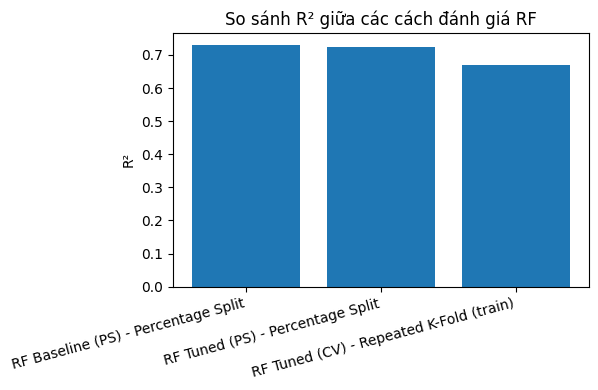

In [14]:
plt.figure(figsize=(6, 4))

labels = comparison_df["Model"] + " - " + comparison_df["Eval"]
r2_values = comparison_df["R2"].values

plt.bar(range(len(r2_values)), r2_values)
plt.xticks(range(len(r2_values)), labels, rotation=15, ha="right")
plt.ylabel("R²")
plt.title("So sánh R² giữa các cách đánh giá RF")
plt.tight_layout()
plt.show()

# Scatter Plot: Actual vs Predicted cho RF Tuned (Percentage Split)

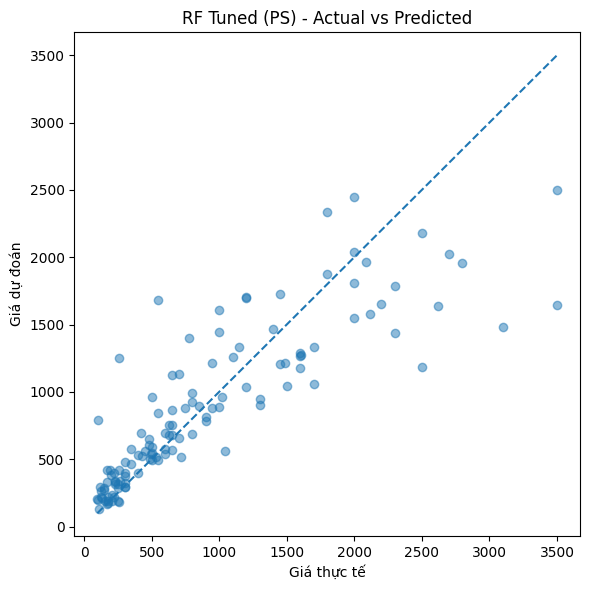

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best_ps, alpha=0.5)
min_val = min(y_test.min(), y_pred_best_ps.min())
max_val = max(y_test.max(), y_pred_best_ps.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.title("RF Tuned (PS) - Actual vs Predicted")
plt.tight_layout()
plt.show()


# Top đặc trưng ảnh hưởng nhất đến giá TV

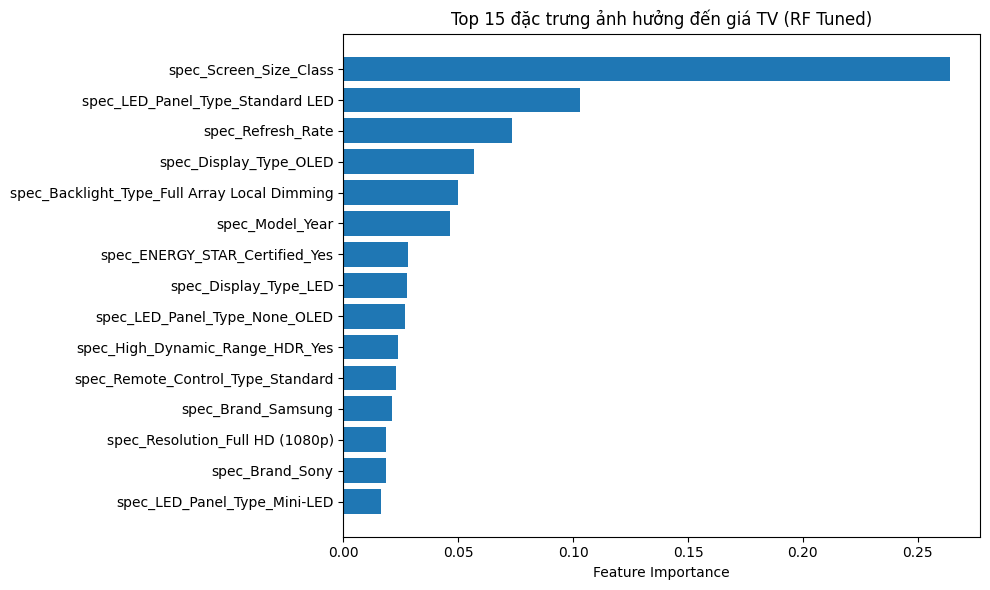

,feature,importance
2,spec_Screen_Size_Class,0.263915
39,spec_LED_Panel_Type_Standard LED,0.102794
1,spec_Refresh_Rate,0.073271
28,spec_Display_Type_OLED,0.056880
4,spec_Backlight_Type_Full Array Local Dimming,0.049826
0,spec_Model_Year,0.046356
29,spec_ENERGY_STAR_Certified_Yes,0.028260
27,spec_Display_Type_LED,0.027825
36,spec_LED_Panel_Type_None_OLED,0.026894
30,spec_High_Dynamic_Range_HDR_Yes,0.023595


In [16]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 15
fi_top = fi_df.head(top_n).iloc[::-1]  # đảo để vẽ barh từ thấp lên cao

plt.figure(figsize=(10, 6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} đặc trưng ảnh hưởng đến giá TV (RF Tuned)")
plt.tight_layout()
plt.show()

display(fi_df.head(top_n))

In [17]:
# ============================================================
# Cell - Save mô hình RF Tuned ra file .pkl để deploy web
# ============================================================

import joblib
import json

# 1) Lưu model
joblib.dump(best_rf, "rf_best_model.pkl")
print("Đã lưu: rf_best_model.pkl")

# 2) Lưu danh sách các cột sau One-Hot (cần thiết để deploy)
feature_cols = list(X_train.columns)
with open("rf_feature_columns.json", "w") as f:
    json.dump(feature_cols, f)

print("Đã lưu: rf_feature_columns.json")


Đã lưu: rf_best_model.pkl
Đã lưu: rf_feature_columns.json
